### investigation into how many tracks are voxelised post-satellite killer

In [1]:
import sys,os,os.path
#sys.path.append("../../")   # cite IC from parent directory
sys.path.append("/gluster/data/next/software/IC_satkill/")
#sys.path.append("/gluster/data/next/software/IC_sophronia/")
#sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
os.environ['ICTDIR']='/gluster/data/next/software/IC_satkill/'


#%load_ext autoreload
#%autoreload 2
#%matplotlib notebook

import time

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'
rcParams['figure.figsize'] = [10, 8]
rcParams['font.size'] = 22

import pandas as pd
import numpy  as np
import tables as tb

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as clrs
from matplotlib.lines import Line2D


import IC.invisible_cities.core.core_functions                   as     coref
import IC.invisible_cities.io.dst_io                           as     dstio

from IC.invisible_cities.cities                 import beersheba as beerfun

from IC.invisible_cities.evm.event_model                          import HitCollection

from IC.invisible_cities.database.load_db       import DataSiPM

from IC.invisible_cities.evm.event_model        import Cluster, Hit
from IC.invisible_cities.types.ic_types         import xy
from IC.invisible_cities.reco.paolina_functions import voxelize_hits, drop_end_point_voxels, make_track_graphs, get_track_energy

from IC.invisible_cities.evm.event_model        import HitEnergy
from IC.invisible_cities.cities.beersheba          import DeconvolutionMode
from IC.invisible_cities.cities.beersheba          import CutType

from IC.invisible_cities.reco import hits_functions as hif

from IC.invisible_cities.reco.deconv_functions import deconvolve
from IC.invisible_cities.reco.deconv_functions import deconvolution_input
from IC.invisible_cities.reco.deconv_functions import InterpolationMethod

import IC.invisible_cities.io.mcinfo_io as mcio

from collections import defaultdict

import matplotlib.cm as cm
from matplotlib.colors import Normalize



def threshold_hits(threshold_charge, same_peak, hitc):
    """
    Applies a threshold to hits and redistributes the charge/energy.

    Parameters
    ----------
    threshold_charge : float
        minimum pes of a hit
    same_peak        : bool
        whether to reassign NN hits' energy only to the hits from the same peak

    Returns
    ----------
    A function that takes HitCollection as input and returns another object with
    only non NN hits of charge above threshold_charge.
    The energy of NN hits is redistributed among neighbors.
    """

    t = hitc.time
    thr_hits = hif.threshold_hits(hitc.hits, threshold_charge     )
    mrg_hits = hif.merge_NN_hits ( thr_hits, same_peak = same_peak)

    cor_hits = []
    for hit in mrg_hits:
        cluster = Cluster(hit.Q, xy(hit.X, hit.Y), hit.var, hit.nsipm)
        xypos   = xy(hit.Xpeak, hit.Ypeak)
        hit     = Hit(hit.npeak, cluster, hit.Z, hit.E, xypos, hit.Ec)
        cor_hits.append(hit)

    new_hitc      = HitCollection(hitc.event, t)
    new_hitc.hits = cor_hits
    return new_hitc





def hits_from_df (dst, skip_NN = False):
    """
    Function that transforms pandas DataFrame dst to HitCollection
    ------
    Parameters
    ------
    dst : pd.DataFrame
        DataFrame with obligatory columns :
                event, npeak, X, Y, Z,  Q, E
        If time, nsipm, Xrms, Yrms, Qc, Ec, track_id are not
        inside dst the default value is set to -1
        If Xpeak, Ypeak not in dst the default value is -1000
    ------
    Returns
    ------
    Dictionary {event_number : HitCollection}
    from here
    https://github.com/next-exp/IC/blob/v2-development/invisible_cities/io/hits_io.py#L16
    """
    all_events = {}
    times = getattr(dst, 'time', [-1]*len(dst))
    for (event, time) , df in dst.groupby(['event', times]):
        #pandas is not consistent with numpy dtypes so we have to change it by hand
        event = np.int32(event)
        hits  = []
        for i, row in df.iterrows():
            Q = getattr(row,'Q', row.E)
            if skip_NN and Q == NN:
                continue
            if hasattr(row, 'Xrms'):
                Xrms  = row.Xrms
                Xrms2 = Xrms**2
            else:
                Xrms = Xrms2 = -1
            if hasattr(row, 'Yrms'):
                Yrms  = row.Yrms
                Yrms2 = Yrms**2
            else:
                Yrms = Yrms2 = -1
            nsipm   = getattr(row, 'nsipm'   , -1   )     # for backwards compatibility
            Qc      = getattr(row, 'Qc'      , -1   )     # for backwards compatibility
            Xpeak   = getattr(row, 'Xpeak'   , -1000)     # for backwards compatibility
            Ypeak   = getattr(row, 'Ypeak'   , -1000)     # for backwards compatibility
            Ec      = getattr(row, 'Ec'      , -1   )     # for backwards compatibility
            trackID = getattr(row, 'track_id', -1   )     # for backwards compatibility
            Ep      = getattr(row, "Ep"      , -1   )     # for backwards compatibility

            hit = Hit(row.npeak            ,
                      Cluster(Q               ,
                              xy(row.X, row.Y),
                              xy(Xrms2, Yrms2),
                              nsipm = nsipm   ,
                              z     = row.Z   ,
                              E     = row.E   ,
                              Qc    = Qc      ),
                      row.Z                ,
                      row.E                ,
                      xy(Xpeak, Ypeak)     ,
                      s2_energy_c = Ec     ,
                      track_id    = trackID,
                      Ep          = Ep     )

            hits.append(hit)

        if len(hits):
            all_events[event] = HitCollection(event, time, hits=hits)

    return all_events

def hitc_to_df_(hitc):
    columns = defaultdict(list)
    for hit in hitc.hits:
        columns["event"   ].append(hitc.event)
        columns["time"    ].append(hitc.time)
        columns["npeak"   ].append(hit .npeak)
        columns["Xpeak"   ].append(hit .Xpeak)
        columns["Ypeak"   ].append(hit .Ypeak)
        columns["nsipm"   ].append(hit .nsipm)
        columns["X"       ].append(hit .X)
        columns["Y"       ].append(hit .Y)
        columns["Xrms"    ].append(hit .Xrms)
        columns["Yrms"    ].append(hit .Yrms)
        columns["Z"       ].append(hit .Z)
        columns["Q"       ].append(hit .Q)
        columns["E"       ].append(hit .E)
        columns["Qc"      ].append(hit .Qc)
        columns["Ec"      ].append(hit .Ec)
        columns["track_id"].append(hit .track_id)
        columns["Ep"      ].append(hit .Ep)
    return pd.DataFrame(columns)






def soph_to_lowTh(df, threshold = 5):
    '''
    Converts sophronia 'RECO/Events' to lowTh events via a rather convoluted process
    Made by me (John Waiton), so dont treat it like a normal function from IC!
    ------
    Parameters
    ------
    df : pd.DataFrame
        DataFrame with obligatory columns :
                event, npeak, X, Y, Z,  Q, E
    threshold: int
        value at which the threshold is set.
    ------
    Returns
    ------
    Dictionary {event_number : HitCollection}
    from here
    '''

    # safety check, to ensure you don't accidentally make a repeating dataframe
    


    # new parameters for threshold, this is silly but I'm copying previous convention
    pes = 1
    threshold = threshold * pes
    same_peak = True

    # convert sophronia RECO/Events to hit collection
    soph_hitc = hits_from_df(df)

    # collect the keys as the event numbers
    soph_hitc_list = list(soph_hitc.keys())

    print("Processing data...")
    # loop over all of these events
    j = 0
    for i in soph_hitc_list:
        j += 1

        if (len(soph_hitc_list)%j == 50): 
            print("{}/{}".format(j, len(soph_hitc_list)))
        # choose i'th event
        soph_hit_event = soph_hitc.get(i)

        # Apply threshold calculation
        soph_hitc_lowTh = threshold_hits(threshold, same_peak, soph_hit_event)

        # convert back to pandas dataframe using hitc_to_df
        soph_hdst_lowTh = hitc_to_df_(soph_hitc_lowTh)

        # check if pandas dataframe with all the events exists yet
        if 'full_soph_df' in locals() and isinstance(full_soph_df, pd.DataFrame):
            full_soph_df = pd.concat([full_soph_df, soph_hdst_lowTh])
        else:
            full_soph_df = soph_hdst_lowTh.copy(deep = True)
    
    return full_soph_df

def collect_min_max_bins(hits):
    '''
    returns all the min, max and mid values you'd need
    as well as the bins
    '''
    x_range = (hits.X.max()-hits.X.min())/2.
    y_range = (hits.Y.max()-hits.Y.min())/2.
    z_range = (hits.Z.max()-hits.Z.min())/2.
    mid_x   = (hits.X.max()+hits.X.min())/2.
    mid_y   = (hits.Y.max()+hits.Y.min())/2.
    mid_z   = (hits.Z.max()+hits.Z.min())/2.
    min_x = hits.X.min()
    min_y = hits.Y.min()
    min_z = hits.Z.min()

    max_x = hits.X.max()
    max_y = hits.Y.max()
    max_z = hits.Z.max()
    #print("X maximum and minimum")
    #print(max_x, min_x)
    #print("")

    #print("Y maximum and minimum")
    #print(max_y, min_y)
    #print("")

    #print("Z maximum and minimum")
    #print(max_z, min_z)

    xbins = int(hits.X.max()-hits.X.min())
    ybins = int(hits.Y.max()-hits.Y.min())
    zbins = int((hits.Z.max()-hits.Z.min())/2.)
    
    array = [x_range, y_range, z_range, mid_x, mid_y, mid_z, min_x, min_y, min_z, max_x, max_y, max_z, xbins, ybins, zbins]
    
    return (array)



def count_tracks_mc(hits_deco):
   
    # stuff needed for paolina track counting
    energy_threshold = 10
    min_voxels = 3
    
    base_vsize = 12 #mm
    the_hits = []

    xs = hits_deco.x
    ys = hits_deco.y
    zs = hits_deco.z
    es = hits_deco.energy

    for x, y, z, e in zip(xs, ys, zs, es):
        if np.isnan(e): continue
        h = Hit(0, Cluster(0, xy(x,y), xy(0,0), 0), z, e*1000, xy(0,0))
        the_hits.append(h)

    voxels = voxelize_hits(the_hits,
                           np.array([base_vsize, base_vsize, base_vsize]), False)

    (mod_voxels, dropped_voxels) = drop_end_point_voxels(voxels, energy_threshold, min_voxels)

    
    tracks = make_track_graphs(mod_voxels)
    tracks = sorted(tracks, key=get_track_energy, reverse = True)
    
    track_no = 0
    for c, t in enumerate(tracks, 0):
        track_no += 1
    
    return track_no    

def return_id(number):
    return str(df_ps[df_ps.particle_id == number].particle_name.values).strip("'[]'")


def count_tracks(hits_deco):
    
    
    
    # stuff needed for paolina track counting
    energy_threshold = 10
    min_voxels = 3
    
    base_vsize = 12 #mm
    the_hits = []

    xs = hits_deco.X
    ys = hits_deco.Y
    zs = hits_deco.Z
    es = hits_deco.E

    for x, y, z, e in zip(xs, ys, zs, es):
        if np.isnan(e): continue
        h = Hit(0, Cluster(0, xy(x,y), xy(0,0), 0), z, e*1000, xy(0,0))
        the_hits.append(h)

    voxels = voxelize_hits(the_hits,
                           np.array([base_vsize, base_vsize, base_vsize]), False)

    (mod_voxels, dropped_voxels) = drop_end_point_voxels(voxels, energy_threshold, min_voxels)

    
    tracks = make_track_graphs(mod_voxels)
    tracks = sorted(tracks, key=get_track_energy, reverse = True)
    
    track_no = 0
    for c, t in enumerate(tracks, 0):
        track_no += 1
    
    return track_no

In [2]:
# loading sophronia file
#soph_file = f'../../../next_misc/Tl_studies/sophronia/sophronia_qthr2.h5'
file_no = 23
soph_file = f'/gluster/data/next/files/TOPOLOGY_John/HYPPOS_DATA_QTHR/Q_THR4/PORT_1a/sophronia/sophronia_' + str(file_no) + '_208Tl.h5'
soph_hdst = dstio.load_dst(soph_file, 'RECO', 'Events')#CHITS/lowTh

# Name of directory the plots are going into
#pre_dir_name = 'qthr2_plot/'

# set q_thr value here
thresh = 4

# Decides if plots are limited by the MC true info
lim_toggle = True


# limits
limit_spacing = 50 # put in the number required division-wise to produce a percentage
                    # eg: 10% of min and max means /10, 50% means /2

display(soph_hdst)

,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
0,440000,4.400005e+11,0,373.926642,-252.626267,1,365.425,-272.125,0.0,0.0,193.040745,11.826087,644.434215,-1.0,0.002424,-1,-1.0
1,440000,4.400005e+11,0,373.926642,-252.626267,1,365.425,-256.575,0.0,0.0,193.040745,17.681160,963.492358,-1.0,0.003472,-1,-1.0
2,440000,4.400005e+11,0,373.926642,-252.626267,1,380.975,-272.125,0.0,0.0,193.040745,9.623188,524.392525,-1.0,0.002162,-1,-1.0
3,440000,4.400005e+11,0,373.926642,-252.626267,1,380.975,-256.575,0.0,0.0,193.040745,13.739130,748.680901,-1.0,0.002898,-1,-1.0
4,440000,4.400005e+11,0,373.926642,-252.626267,1,349.875,-272.125,0.0,0.0,196.017281,10.724638,312.642957,-1.0,0.001104,-1,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152512,440666,4.406662e+11,1,253.583736,206.027674,1,225.475,209.925,0.0,0.0,713.026453,7.188406,419.340262,-1.0,0.001391,-1,-1.0
152513,440666,4.406662e+11,1,253.583736,206.027674,1,225.475,225.475,0.0,0.0,713.026453,7.826087,456.539791,-1.0,0.001532,-1,-1.0
152514,440666,4.406662e+11,1,253.583736,206.027674,1,225.475,241.025,0.0,0.0,713.026453,10.086957,588.429087,-1.0,0.001993,-1,-1.0
152515,440666,4.406662e+11,1,253.583736,206.027674,1,241.025,225.475,0.0,0.0,713.026453,11.884058,693.264125,-1.0,0.002345,-1,-1.0


In [3]:
# process
hdst = soph_to_lowTh(soph_hdst, threshold = thresh)


Processing data...
139/328
278/328


In [4]:
# Input file and some event IDs to look at.
dist = 12
typefile = 'esmeralda' #'esmeralda'
#file = f'/Users/halmamol/NEXT/files/NEXT100/separated/esmeralda/esmeralda_10_sep.h5'
#file = f'../../../Tl_studies/LPR/208Tl/PORT_2a/prod/esmeralda/esmeralda_180_208Tl.h5'
#file = f'/Users/halmamol/NEXT/files/FLEX/ELdistMask/Xe/bb0nu/{typefile}/NextFlex.bb0nu.FLEXELdist{dist}mask.0.detsim.h5'
evts = [90] #15, 30, 90
pitch = 15.55
detector_db     = '/gluster/data/next/software/IC_satkill/IC/invisible_cities/database/localdb.NEXT100DB.sqlite3'
run_number      = -1

datatype = 'MC'


# Parameters involved in beersheba city and the deconvolution.

'''
## FROM OLD TESTING
deconv_params = dict(
  q_cut           = 5, #5 for 6mm  - 5 for 6mm
  drop_dist       = [16, 16],
  #psf_fname       = f'/Users/halmamol/NEXT/PSF_FLEX100_mask{dist}_lowQE.h5',     
  psf_fname       = f'../data/data/LightTables/NEXT100_PSF_kr83m.h5',     
  e_cut           = 6e-3, #15 for 6mm  - 15 for 6mm
  n_iterations    = 100, #150 for 6mm  - 150 for 6mm
  iteration_tol   = 1e-10,
  sample_width    = [15.55, 15.55],
  bin_size        = [ 1,  1],
  diffusion       = (1., 0.2),
  n_dim           = 2,
  deconv_mode     = DeconvolutionMode.joint)#,
 # energy_type     = HitEnergy.Ec,
 # cut_type        = CutType.abs,
 # inter_method    = InterpolationMethod.cubic)
'''

# new parameters for threshold
pes = 1
threshold = thresh * pes
same_peak = True

deconv_params = dict(
                  drop_dist       = [16., 16.],
                  psf_fname       = f'/gluster/data/next/files/TOPOLOGY_John/LPR/LightTables/NEXT100_PSF_kr83m_5bar.h5',
                  q_cut           = thresh,                   # WE HAVE MANUALLY CHANGED THIS FROM 10 -> 5 HERE
                  e_cut           = 9e-3,                # WE HAVE MANUALLY CHANGED THIS FROM 12e-3 TO 6e-3
                  n_iterations    = 75,
                  iteration_tol   = 1e-10,
                  sample_width    = [15.55, 15.55],
                  bin_size        = [ 1.,  1.],
                  satellite_iter  = 50,                       # after how many iterations do you start scanning? 
                  satellite_dist  = 2,                        # how far away do two clouds have to be to be considered unique
                  satellite_size  = 10,                       # maximum size of satellites, beyond which they are considered signal.
                  energy_type     = HitEnergy.Ec,               #Removing these variables because they were previously? 
                  diffusion       = (1.440, 1.440),
                  deconv_mode     = DeconvolutionMode.joint,
                  n_dim           = 2,
                  cut_type        = CutType.abs,              #Removing these variables because they were previously?
                  inter_method    = InterpolationMethod.cubic)            #Removing these variables because they were previously?  




#DeconvolutionMode
                
deconv_params_   = {k : v for k, v in deconv_params.items() if k not in ['q_cut', 'drop_dist']}

# Couple of functions used in beersheba.
cut_sensors       = beerfun.cut_over_Q   (deconv_params['q_cut'    ], ['E', 'Ec'])
drop_sensors      = beerfun.drop_isolated(deconv_params['drop_dist'], ['E', 'Ec'])

In [5]:
import fom_fitting.functions as func


posi_evts = func.from_file_positron(soph_file)
posi_evt_ids = posi_evts.event_id.to_numpy()*2
print(posi_evts.event_id.to_numpy()*2)

[440006 440010 440014 440052 440060 440080 440118 440136 440140 440146
 440174 440176 440234 440260 440268 440276 440334 440358 440362 440398
 440408 440428 440446 440466 440478 440502 440504 440506 440530 440536
 440546 440562 440576 440640 440650]


In [16]:
# select all the positron events, check their positions. Why do we not retain them? What happens?

In [15]:
file_number = file_no
evt = int(460486/2)
dir_name = "Tl208_" + str(file_number) + "_event_" + str(int(evt))


In [16]:
pd.set_option('display.max_rows', 500)
df_ps = pd.read_hdf(soph_file, 'MC/particles')
df_ps = df_ps[df_ps.event_id == evt]
df_ps_K = df_ps[df_ps.kin_energy < 34e-3]
df_ps_K = df_ps_K[df_ps_K.kin_energy > 29e-3]
display(df_ps_K)

,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc


/tmp/ipykernel_1492810/3901995842.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  this_evt_true_info['particle_name'] = this_evt_true_info['particle_id'].apply(return_id)


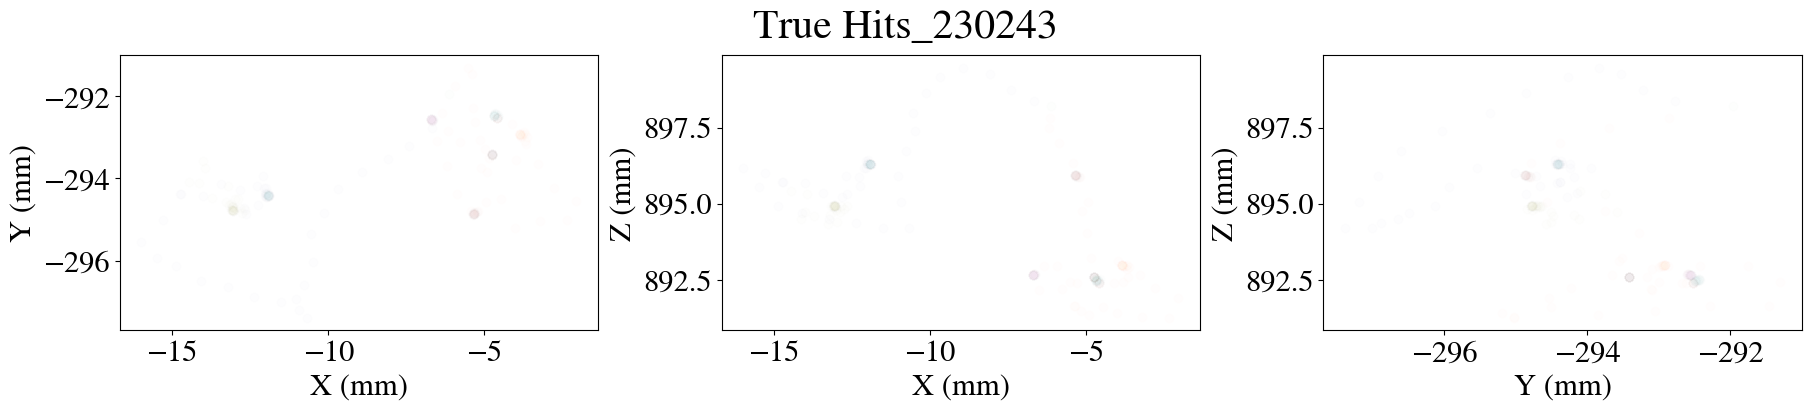

No handles with labels found to put in legend.


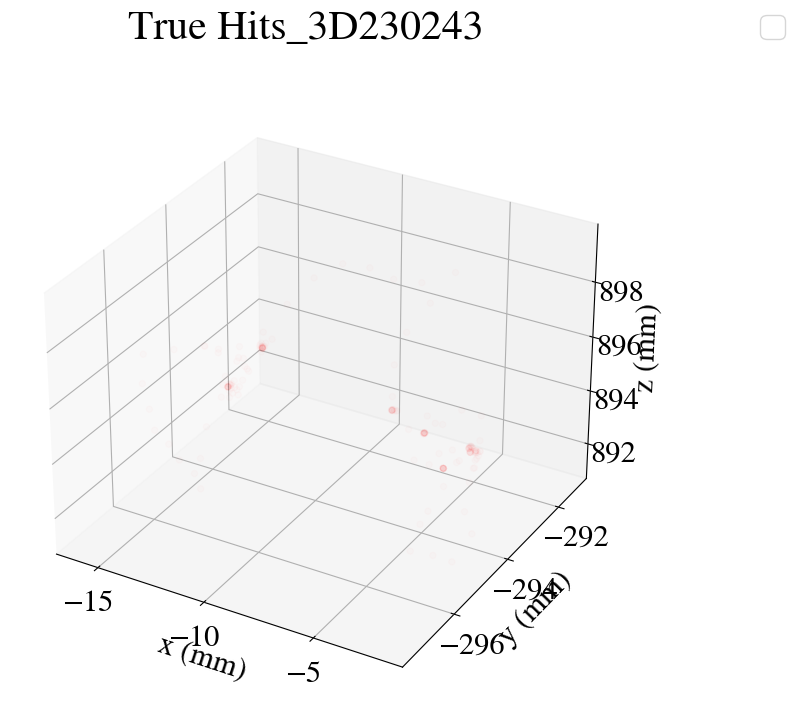

In [17]:
# load in MC
evtmap = mcio.load_eventnumbermap(soph_file).set_index('nexus_evt')
true_info = mcio.load_mchits_df(soph_file).reset_index()
true_info.event_id = true_info.event_id.map(evtmap.evt_number)


this_evt_true_info = true_info[true_info.event_id == evt*2]

xtMC = this_evt_true_info.x
ytMC = this_evt_true_info.y
ztMC = this_evt_true_info.z
etMC = this_evt_true_info.energy*1000


df_ps = pd.read_hdf(soph_file, 'MC/particles')
df_ps = df_ps[df_ps.event_id == evt]
#for pid, df in this_evt_true_info.groupby('particle_id'):
this_evt_true_info['particle_name'] = this_evt_true_info['particle_id'].apply(return_id)
fug, axus = plt.subplots(1, 3, figsize=(18, 4), constrained_layout=True)
fug.suptitle('True Hits_' + str(evt), fontsize=30)
#fig.tight_layout()
added_labels = set()
# Dictionary to store custom handles for the legend
legend_handles = {}
for pid, df in this_evt_true_info.groupby('particle_id'):
    if pid == 31:                                                           # <<<<< change this manually
        alp = 1
    elif pid == 31:                                                           # <<<<< change this manually
        alp = 1
    else:
        alp = 0.007
    xt = df.x
    yt = df.y
    zt = df.z
    et = df.energy*1000


    axus[0].scatter(xt, yt,  alpha=alp, label = str(pid))
    axus[1].scatter(xt, zt,  alpha=alp, label = str(pid))
    axus[2].scatter(yt, zt,  alpha=alp, label = str(pid))


    axus[0].set_xlabel('X (mm)');
    axus[0].set_ylabel('Y (mm)');
    axus[1].set_xlabel('X (mm)');
    axus[1].set_ylabel('Z (mm)');
    axus[2].set_xlabel('Y (mm)');
    axus[2].set_ylabel('Z (mm)');

# Retrieve legend handles and labels
handles, labels = axus[0].get_legend_handles_labels()

plt.show()

feg = plt.figure()
ax = feg.add_subplot(111, projection='3d')
for pid, df in this_evt_true_info.groupby('particle_id'):
    xt = df.x
    yt = df.y
    zt = df.z
    et = df.energy*1000
    
    
    if pid == 31:                                                           # <<<<< change this manually
        alp = 1
        colr = 'blue'
        labl = 'x-ray event ' + str(pid)
        p = ax.scatter(xt, yt, zt, alpha = alp, color=colr, label = labl)  
    #elif pid == 46:                                                           # <<<<< change this manually
    #    alp = 1
    #    colr = 'blue'
    #    labl = 'x-ray event ' + str(pid)
    #    p = ax.scatter(xt, yt, zt, alpha = alp, color=colr, label = labl)
    else:
        alp = 0.01
        colr = 'red'
        p = ax.scatter(xt, yt, zt, alpha = alp, color=colr)



    

ax.set_xlabel('x (mm)')
ax.set_ylabel('y (mm)')
ax.set_zlabel('z (mm)')

feg.suptitle('True Hits_3D' + str(evt), fontsize=30)

feg.legend()
plt.show()
# Create a single legend for all subplots
#legend = fug.legend(handles, labels, fontsize=15, loc = 'lower left')
#for handle in legend.legendHandles:
#    handle.set_alpha(1.0)


In [11]:
print(str(df_ps[df_ps.particle_id == 54].particle_name.values).strip("'[]'") + " : " + str(df_ps[df_ps.particle_id == 54].creator_proc.values).strip("'[]'"))

 : 


### deconv all events and compare to true

In [6]:
if (datatype == 'MC'):
    evtmap = mcio.load_eventnumbermap(soph_file).set_index('nexus_evt')
    true_info = mcio.load_mchits_df(soph_file).reset_index()
    true_info.event_id = true_info.event_id.map(evtmap.evt_number)

# satellite killer
event_ids = []

r_lim = 415
z_upper = 1170
z_lower = 20





file_number = file_no # alter this
q = 0
cap = len(hdst.event.unique())

# this line applies the satellite killer
deconv_params_['satellite_iter'] = 25

# true track number
true_trk_number = []
time_spent = []
track_number = []

for i in range(len(hdst.event.unique())):
    print("event {},{}/{}".format(hdst.event.unique()[i],q, cap))
    q += 1
    if (q == cap):
        break
        
    #evt = int(saved_signal_evts[i]*2)
    evt = hdst.event.unique()[i]
    # signal events is the lower half
    dir_name = "plots/" + "event_" + str(hdst.event.unique()[i]) + "_file_" + str(file_number)
    if not os.path.exists(dir_name + '/iterations'):
        os.makedirs(dir_name + '/iterations', exist_ok = True)
    

    
    
    
    # check first that the MCof this event is within the 
    this_evt_true_info = true_info[true_info.event_id == evt]

    xtMC = this_evt_true_info.x
    ytMC = this_evt_true_info.y
    ztMC = this_evt_true_info.z
    etMC = this_evt_true_info.energy*1000
    
    # Z
    z_max = ztMC.max()
    z_min = ztMC.min()
    
    # Radius
    r = np.sqrt(xtMC**2 + ytMC**2)
    r_max = r.max()

    if ((z_max > z_upper) or (z_min < z_lower) or (r_max > r_lim)):
        print("MC Max reached at: {}, {}, {}".format(z_max, z_min, r_max))
    else:
        hits = hdst[hdst.event == evt]



        x_range, y_range, z_range, mid_x, mid_y, mid_z, min_x, min_y, min_z, max_x, max_y, max_z, xbins, ybins, zbins = collect_min_max_bins(hits)



        hits_cut = coref.timefunc(cut_sensors)(hits.copy())
        hits_drop = coref.timefunc(drop_sensors)(hits_cut.copy())

        # this is to stop your number of iterations vanishing because of the below function, as you're rewriting deconv_params_
        if 'save_state' in locals():
            deconv_params_['n_iterations'] = save_state
        else:
            # first time round, so set it
            save_state = deconv_params_['n_iterations']

        iter_E = []
        iter_no = []
        i = 0
        p = 0


        deconvolver = beerfun.deconvolve_signal(DataSiPM(detector_db, run_number), **deconv_params_)

        t0 = time.time()

        hits_deco = coref.timefunc(deconvolver)(hits_drop.copy())




        # Z
        z_max = hits_deco.Z.max()
        z_min = hits_deco.Z.min()

        # Radius
        r = np.sqrt(hits_deco.X**2 + hits_deco.Y**2)
        r_max = r.max()

        if ((z_max > z_upper) or (z_min < z_lower) or (r_max > r_lim)):

            print("RECO Max reached at: {}, {}, {}".format(z_max, z_min, r_max))
        else:



            time_spent.append(time.time() - t0)


            # plot the MC

                   # load in MC
            evtmap = mcio.load_eventnumbermap(soph_file).set_index('nexus_evt')
            true_info = mcio.load_mchits_df(soph_file).reset_index()
            true_info.event_id = true_info.event_id.map(evtmap.evt_number)


            #this_evt_true_info = true_info[true_info.event_id == evt]

            #xtMC = this_evt_true_info.x
            #ytMC = this_evt_true_info.y
            #ztMC = this_evt_true_info.z
            #etMC = this_evt_true_info.energy*1000


            fog = plt.figure()
            ax = fog.add_subplot(111, projection='3d')

            p = ax.scatter(xtMC, ytMC, ztMC, alpha = 0.1, color='red')
            cb = fog.colorbar(p, ax=ax)
            cb.set_label('Energy (keV)')


            ax.set_xlabel('x (mm)')
            ax.set_ylabel('y (mm)')
            ax.set_zlabel('z (mm)')
            fog.suptitle('True Hits_3D' + dir_name, fontsize=30)

            fog.savefig(dir_name + '/MC_3D.png')
            plt.close(fog)

            # collect true track number here
            true_trk_number.append(count_tracks_mc(this_evt_true_info))


            df_ps = pd.read_hdf(soph_file, 'MC/particles')
            df_ps = df_ps[df_ps.event_id == evt/2]

            #for pid, df in this_evt_true_info.groupby('particle_id'):
            this_evt_true_info['particle_name'] = this_evt_true_info['particle_id'].apply(return_id)

            fug, axus = plt.subplots(1, 3, figsize=(18, 4), constrained_layout=True)
            fug.suptitle('True Hits_' + dir_name, fontsize=30)
            #fig.tight_layout()
            added_labels = set()
            # Dictionary to store custom handles for the legend
            legend_handles = {}
            for pid, df in this_evt_true_info.groupby('particle_name'):

                xt = df.x
                yt = df.y
                zt = df.z
                et = df.energy*1000


                axus[0].scatter(xt, yt,  alpha=0.1, label = str(pid))
                axus[1].scatter(xt, zt,  alpha=0.1, label = str(pid))
                axus[2].scatter(yt, zt,  alpha=0.1, label = str(pid))


                axus[0].set_xlabel('X (mm)');
                axus[0].set_ylabel('Y (mm)');
                axus[1].set_xlabel('X (mm)');
                axus[1].set_ylabel('Z (mm)');
                axus[2].set_xlabel('Y (mm)');
                axus[2].set_ylabel('Z (mm)');

            # Retrieve legend handles and labels
            handles, labels = axus[0].get_legend_handles_labels()

            # Create a single legend for all subplots
            legend = fug.legend(handles, labels, fontsize=15, loc = 'lower left')
            for handle in legend.legendHandles:
                handle.set_alpha(1.0)

            fug.savefig(dir_name + '/MC_true.png')
            plt.close(fug)



            # if its within fiducial, keep it
            event_ids.append(evt)


            x = hits_deco.X
            y = hits_deco.Y
            z = hits_deco.Z
            e = hits_deco.E

            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            p = ax.scatter(x, y, z, c=e, alpha = 0.07, cmap='viridis')
            cb = fig.colorbar(p, ax=ax)
            cb.set_label('Energy (keV)')

            ax.scatter(xtMC, ytMC, ztMC, color='red')

            ax.set_xlabel('x (mm)')
            ax.set_ylabel('y (mm)')
            ax.set_zlabel('z (mm)')

            fig.suptitle('3D_deconvolved_' + str(int(evt)) + "_iteration " + str(deconv_params_['n_iterations']), fontsize=30)
            #fig.savefig(pre_dir_name + dir_name +  "/3D_deconvolved_plot")
            fig.savefig(dir_name + '/iterations/3D_plot_' + str(deconv_params_['n_iterations']) + '_iter_MCinc.png')
            plt.close(fig)

            # stick track number on after finishing
            track_number.append(count_tracks(hits_deco))



event 440000,0/328
MC Max reached at: 572.6083374023438, 192.69615173339844, 491.1475524902344
event 440002,1/328
MC Max reached at: 1004.6775512695312, 886.6266479492188, 487.0175476074219
event 440004,2/328
Time spent in cut_over_Q: 0.013531684875488281 s
Time spent in drop_isolated: 0.012099742889404297 s
Time spent in apply_deconvolution: 2.982851028442383 s
event 440006,3/328
MC Max reached at: 906.666259765625, 503.9477844238281, 487.2205810546875
event 440008,4/328
MC Max reached at: 821.4830932617188, 760.429931640625, 455.43585205078125
event 440010,5/328
MC Max reached at: 677.7439575195312, 589.8213500976562, 496.853759765625
event 440012,6/328
MC Max reached at: 675.5488891601562, 428.2059020996094, 418.5527648925781
event 440014,7/328
MC Max reached at: 544.576904296875, 23.892805099487305, 492.2012634277344
event 440016,8/328
MC Max reached at: 655.9264526367188, 541.2698974609375, 480.4746398925781
event 440018,9/328
MC Max reached at: 774.4407958984375, 434.160308837890

In [7]:
np.save('time_spent_satkill' + str(file_no) + '.npy', np.array(time_spent))
np.save('track_num_satkill' + str(file_no) + '.npy', np.array(track_number))
np.save('true_trk_num' + str(file_no) + '.npy', np.array(true_trk_number))
np.save('eventids_satkill' + str(file_no) + '.npy', np.array(event_ids))

### No satellite killer here

In [8]:
if (datatype == 'MC'):
    evtmap = mcio.load_eventnumbermap(soph_file).set_index('nexus_evt')
    true_info = mcio.load_mchits_df(soph_file).reset_index()
    true_info.event_id = true_info.event_id.map(evtmap.evt_number)

# satellite killer
event_ids_nosat = []

r_lim = 415
z_upper = 1170
z_lower = 20





file_number = file_no # alter this
q = 0
cap = len(hdst.event.unique())

# this line applies the satellite killer
deconv_params_['satellite_iter'] = 9999

# true track number
true_trk_number_nosat = []
time_spent_nosat = []
track_number_nosat = []

for i in range(len(hdst.event.unique())):
    print("event {},{}/{}".format(hdst.event.unique()[i],q, cap))
    q += 1
    if (q == cap):
        break
        
    #evt = int(saved_signal_evts[i]*2)
    evt = hdst.event.unique()[i]
    # signal events is the lower half
    dir_name = "plots/" + "event_" + str(hdst.event.unique()[i]) + "_file_" + str(file_number)
    if not os.path.exists(dir_name + '/iterations_nosat'):
        os.makedirs(dir_name + '/iterations_nosat', exist_ok = True)
    

    
    
    
    # check first that the MCof this event is within the 
    this_evt_true_info = true_info[true_info.event_id == evt]

    xtMC = this_evt_true_info.x
    ytMC = this_evt_true_info.y
    ztMC = this_evt_true_info.z
    etMC = this_evt_true_info.energy*1000
    
    # Z
    z_max = ztMC.max()
    z_min = ztMC.min()
    
    # Radius
    r = np.sqrt(xtMC**2 + ytMC**2)
    r_max = r.max()

    if ((z_max > z_upper) or (z_min < z_lower) or (r_max > r_lim)):
        print("MC Max reached at: {}, {}, {}".format(z_max, z_min, r_max))
    else:
        hits = hdst[hdst.event == evt]



        x_range, y_range, z_range, mid_x, mid_y, mid_z, min_x, min_y, min_z, max_x, max_y, max_z, xbins, ybins, zbins = collect_min_max_bins(hits)



        hits_cut = coref.timefunc(cut_sensors)(hits.copy())
        hits_drop = coref.timefunc(drop_sensors)(hits_cut.copy())

        # this is to stop your number of iterations vanishing because of the below function, as you're rewriting deconv_params_
        if 'save_state' in locals():
            deconv_params_['n_iterations'] = save_state
        else:
            # first time round, so set it
            save_state = deconv_params_['n_iterations']

        iter_E = []
        iter_no = []
        i = 0
        p = 0


        deconvolver = beerfun.deconvolve_signal(DataSiPM(detector_db, run_number), **deconv_params_)

        t0 = time.time()

        hits_deco = coref.timefunc(deconvolver)(hits_drop.copy())




        # Z
        z_max = hits_deco.Z.max()
        z_min = hits_deco.Z.min()

        # Radius
        r = np.sqrt(hits_deco.X**2 + hits_deco.Y**2)
        r_max = r.max()

        if ((z_max > z_upper) or (z_min < z_lower) or (r_max > r_lim)):

            print("RECO Max reached at: {}, {}, {}".format(z_max, z_min, r_max))
        else:



            time_spent_nosat.append(time.time() - t0)


            # plot the MC

                   # load in MC
            evtmap = mcio.load_eventnumbermap(soph_file).set_index('nexus_evt')
            true_info = mcio.load_mchits_df(soph_file).reset_index()
            true_info.event_id = true_info.event_id.map(evtmap.evt_number)


            this_evt_true_info = true_info[true_info.event_id == evt]

            xtMC = this_evt_true_info.x
            ytMC = this_evt_true_info.y
            ztMC = this_evt_true_info.z
            etMC = this_evt_true_info.energy*1000


            fog = plt.figure()
            ax = fog.add_subplot(111, projection='3d')

            p = ax.scatter(xtMC, ytMC, ztMC, alpha = 0.1, color='red')
            cb = fog.colorbar(p, ax=ax)
            cb.set_label('Energy (keV)')


            ax.set_xlabel('x (mm)')
            ax.set_ylabel('y (mm)')
            ax.set_zlabel('z (mm)')
            fog.suptitle('True Hits_3D' + dir_name, fontsize=30)

            fog.savefig(dir_name + '/MC_3D.png')
            plt.close(fog)

            # collect true track number here
            true_trk_number_nosat.append(count_tracks_mc(this_evt_true_info))


            df_ps = pd.read_hdf(soph_file, 'MC/particles')
            df_ps = df_ps[df_ps.event_id == evt/2]

            #for pid, df in this_evt_true_info.groupby('particle_id'):
            this_evt_true_info['particle_name'] = this_evt_true_info['particle_id'].apply(return_id)

            fug, axus = plt.subplots(1, 3, figsize=(18, 4), constrained_layout=True)
            fug.suptitle('True Hits_' + dir_name, fontsize=30)
            #fig.tight_layout()
            added_labels = set()
            # Dictionary to store custom handles for the legend
            legend_handles = {}
            for pid, df in this_evt_true_info.groupby('particle_name'):

                xt = df.x
                yt = df.y
                zt = df.z
                et = df.energy*1000


                axus[0].scatter(xt, yt,  alpha=0.1, label = str(pid))
                axus[1].scatter(xt, zt,  alpha=0.1, label = str(pid))
                axus[2].scatter(yt, zt,  alpha=0.1, label = str(pid))


                axus[0].set_xlabel('X (mm)');
                axus[0].set_ylabel('Y (mm)');
                axus[1].set_xlabel('X (mm)');
                axus[1].set_ylabel('Z (mm)');
                axus[2].set_xlabel('Y (mm)');
                axus[2].set_ylabel('Z (mm)');

            # Retrieve legend handles and labels
            handles, labels = axus[0].get_legend_handles_labels()

            # Create a single legend for all subplots
            legend = fug.legend(handles, labels, fontsize=15, loc = 'lower left')
            for handle in legend.legendHandles:
                handle.set_alpha(1.0)

            fug.savefig(dir_name + '/MC_true.png')
            plt.close(fug)



            # if its within fiducial, keep it
            event_ids_nosat.append(evt)


            x = hits_deco.X
            y = hits_deco.Y
            z = hits_deco.Z
            e = hits_deco.E

            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            p = ax.scatter(x, y, z, c=e, alpha = 0.07, cmap='viridis')
            cb = fig.colorbar(p, ax=ax)
            cb.set_label('Energy (keV)')

            ax.scatter(xtMC, ytMC, ztMC, color='red')

            ax.set_xlabel('x (mm)')
            ax.set_ylabel('y (mm)')
            ax.set_zlabel('z (mm)')

            fig.suptitle('3D_deconvolved_' + str(int(evt)) + "_iteration " + str(deconv_params_['n_iterations']), fontsize=30)
            #fig.savefig(pre_dir_name + dir_name +  "/3D_deconvolved_plot")
            fig.savefig(dir_name + '/iterations_nosat/3D_plot_' + str(deconv_params_['n_iterations']) + '_iter_MCinc.png')
            plt.close(fig)

            # stick track number on after finishing
            track_number_nosat.append(count_tracks(hits_deco))



event 440000,0/328
MC Max reached at: 572.6083374023438, 192.69615173339844, 491.1475524902344
event 440002,1/328
MC Max reached at: 1004.6775512695312, 886.6266479492188, 487.0175476074219
event 440004,2/328
Time spent in cut_over_Q: 0.011603116989135742 s
Time spent in drop_isolated: 0.011712074279785156 s
Time spent in apply_deconvolution: 2.7610740661621094 s


/tmp/ipykernel_1501904/3392162680.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  this_evt_true_info['particle_name'] = this_evt_true_info['particle_id'].apply(return_id)


event 440006,3/328
MC Max reached at: 906.666259765625, 503.9477844238281, 487.2205810546875
event 440008,4/328
MC Max reached at: 821.4830932617188, 760.429931640625, 455.43585205078125
event 440010,5/328
MC Max reached at: 677.7439575195312, 589.8213500976562, 496.853759765625
event 440012,6/328
MC Max reached at: 675.5488891601562, 428.2059020996094, 418.5527648925781
event 440014,7/328
MC Max reached at: 544.576904296875, 23.892805099487305, 492.2012634277344
event 440016,8/328
MC Max reached at: 655.9264526367188, 541.2698974609375, 480.4746398925781
event 440018,9/328
MC Max reached at: 774.4407958984375, 434.1603088378906, 489.7088317871094
event 440020,10/328
MC Max reached at: 904.6998901367188, 231.15304565429688, 433.3019714355469
event 440022,11/328
MC Max reached at: 437.7174377441406, 415.02801513671875, 470.2699279785156
event 440024,12/328
MC Max reached at: 1137.58837890625, 666.8818359375, 420.2129211425781
event 440026,13/328
MC Max reached at: 941.1812744140625, 166

In [9]:
np.save('time_spent_no_satkill' + str(file_no) + '.npy', np.array(time_spent_nosat))
np.save('track_num_no_satkill' + str(file_no) + '.npy', np.array(track_number_nosat))
np.save('true_trk_num_nosatkill' + str(file_no) + '.npy', np.array(true_trk_number_nosat))
np.save('eventids_nosat' + str(file_no) + '.npy', np.array(event_ids_nosat))

In [ ]:
#event_ids = [520000, 520012, 520014, 520020, 520022, 520024, 520026, 520032, 520034, 520036, 520046, 520048, 520050, 520052, 520054, 520058, 520060, 520062, 520070, 520076, 520082, 520086, 520100, 520112, 520124, 520126, 520128, 520134, 520150, 520152, 520154, 520160, 520168, 520170, 520188, 520190, 520194, 520198, 520202, 520204, 520212, 520214, 520220, 520222, 520236, 520244, 520246, 520252, 520264, 520268, 520270, 520280, 520284, 520286, 520290, 520298, 520300, 520310, 520314, 520316, 520318, 520320, 520324, 520326, 520328, 520332, 520334, 520336, 520342, 520350, 520354, 520366, 520372, 520390, 520392, 520396, 520398, 520400, 520404, 520414, 520416, 520430, 520432, 520448, 520450, 520454, 520456, 520458, 520470, 520474, 520476, 520488, 520500, 520504, 520506, 520514, 520520, 520524, 520526, 520530, 520532, 520534, 520540, 520546, 520548, 520550, 520558, 520560, 520564, 520568, 520576, 520580, 520588, 520590, 520592, 520596, 520604, 520606, 520614, 520618, 520620, 520628, 520634, 520636]
print(event_ids)
print(event_ids_nosat)

In [8]:
# load them in if you havent already got them
#time_spent = np.load('time_spent_satkill24.npy')
#track_number = np.load('track_num_satkill24.npy')
#true_trk_number = np.load('true_trk_num24.npy')
#event_ids = np.load('eventids_satkill24.npy')

#time_spent_nosat = np.load('time_spent_no_satkill24.npy')
#track_number_nosat = np.load('track_num_no_satkill24.npy')
#true_trk_number_nosat = np.load('true_trk_num_nosatkill24.npy')
#event_ids_nosat = np.load('eventids_nosat24.npy')
#print(event_ids)
#print(track_number)

Text(0, 0.5, 'count')

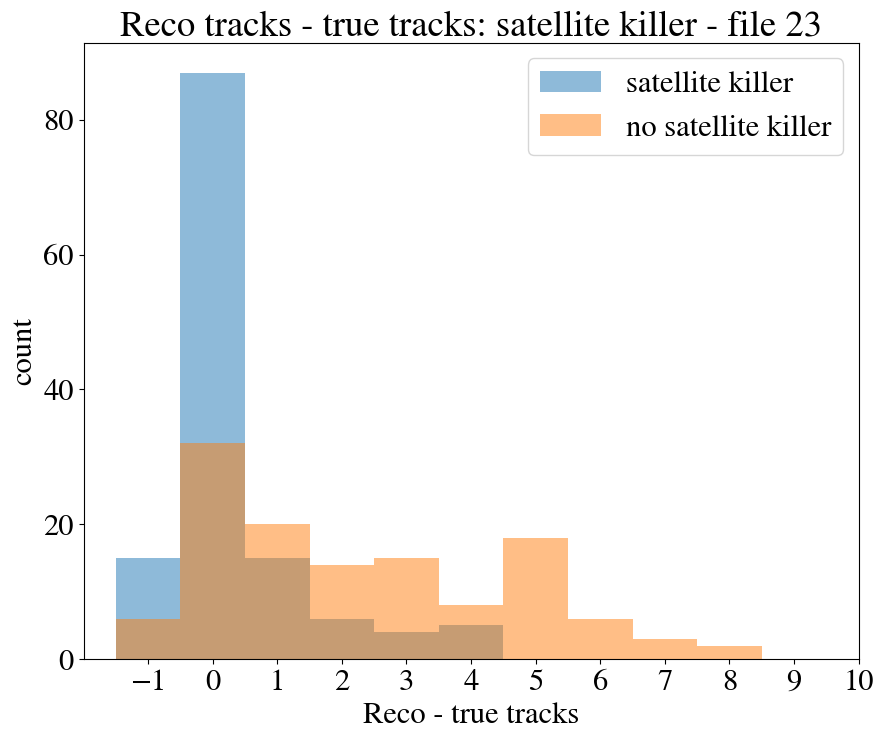

In [10]:
# FIX THE RANGES
q = np.array([a - b for a, b in zip(track_number, true_trk_number)])
p = np.array([a - b for a, b in zip(track_number_nosat, true_trk_number_nosat)])
plt.hist(q, label = 'satellite killer', alpha = 0.5, bins=np.arange(-1,6)-0.5)
plt.hist(p, label = 'no satellite killer', alpha = 0.5, bins = np.arange(-1,10)-0.5)
plt.xticks(np.arange(-1, 11, 1.0))
plt.title('Reco tracks - true tracks: satellite killer - file ' + str(file_no))
plt.xlabel('Reco - true tracks')
plt.legend()
plt.ylabel('count')

In [13]:
select = (q != -1)
select_nosat = (p != -1)
print("reco-true satellite killer")
print(q)
print("reco-true no satellite killer")
print(p)
overkill_ids = np.ma.masked_array(event_ids, select)
overkill_ids_nosat = np.ma.masked_array(event_ids_nosat, select_nosat)
print('satellite killer true number of tracks')
print(true_trk_number)
print("satellite killer number of tracks")
print(track_number)
print("")
print("")
print('satellite killer true number of tracks')
print(true_trk_number_nosat)
print("no satellite killer number of tracks")
print(track_number_nosat)
print("-1 events within satellite killer : reco - true")
print(overkill_ids)
print("-1 events without satellite killer : reco - true")
print(overkill_ids_nosat)

reco-true satellite killer
[ 0  0  0  6  0  0  0  2  0  1  0  0  0  0  2  0  0  3  0  4  0  0  0  0
  0  0  0  0  0  0  0  0  0  1  7  0  0  1  1  0  0  0  4  4  0  1  0 -1
  0  0  0  0  1  0  0  3 -1  2  0  1  1  7  1  0  0  0  0  1  4  0  0  0
  3  0  0  0  0  0  0  0 -1  0  0  0  4 -1  0  1  0  0 -1  0  0  0  2 -1
  0  0  0  0 -1  2  1 -1  0  0  0  0 -1  0  0  3 -1  0  0  0  0  0  0  0
  0  2 -1 -1  1  0 -1  0  0  0  1 -1 -1  0  1]
reco-true no satellite killer
[ 3  7  6  5  0  0  0  2  0  1  1  2  3  2  2  0  7  0  3  1  4  0  0  3
  5  3  3  1  0  5  3  1  2  9  5  3  6  4  0  0  6  8  5  2  1  3  0  2
  0  0  4  2  3  7  5  4  2  5  9  0  0  5  5  0  3  3  0  1  8  1  6  1
  0  0  0  2  5  4  5  5  0  0  6  0  0  4  5  1  1  1  0  1  5  0  1  3
 -1  1  1  1  2  2  0  4 -1  5  4  6  0  0  2  5  5  2 -1 -1  1  0  5  1
  0  3  1 -1 -1 12  3]
satellite killer true number of tracks
[1, 2, 2, 1, 2, 1, 1, 5, 1, 5, 2, 1, 2, 1, 1, 5, 1, 2, 1, 4, 2, 1, 1, 1, 1, 1, 3, 4, 1, 1, 2, 1, 3, 1, 4

Event: 440052
Number of true tracks: 1
Number of satkill tracks: 1
Number of non-satkill tracks: 1



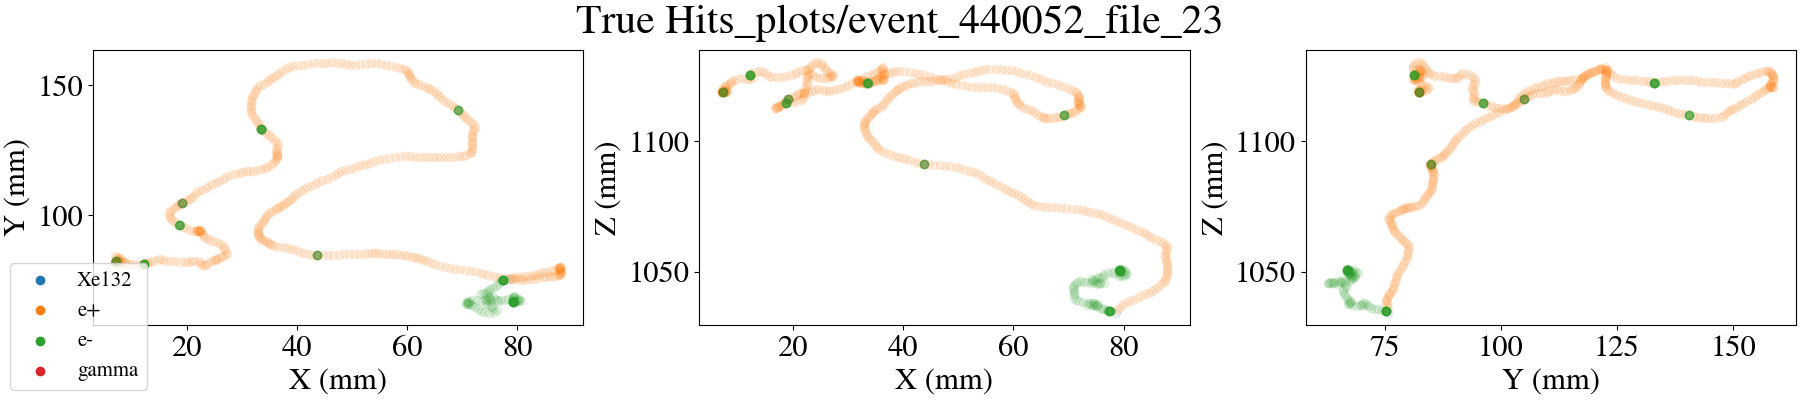

Event: 440060
Number of true tracks: 1
Number of satkill tracks: 1
Number of non-satkill tracks: 1



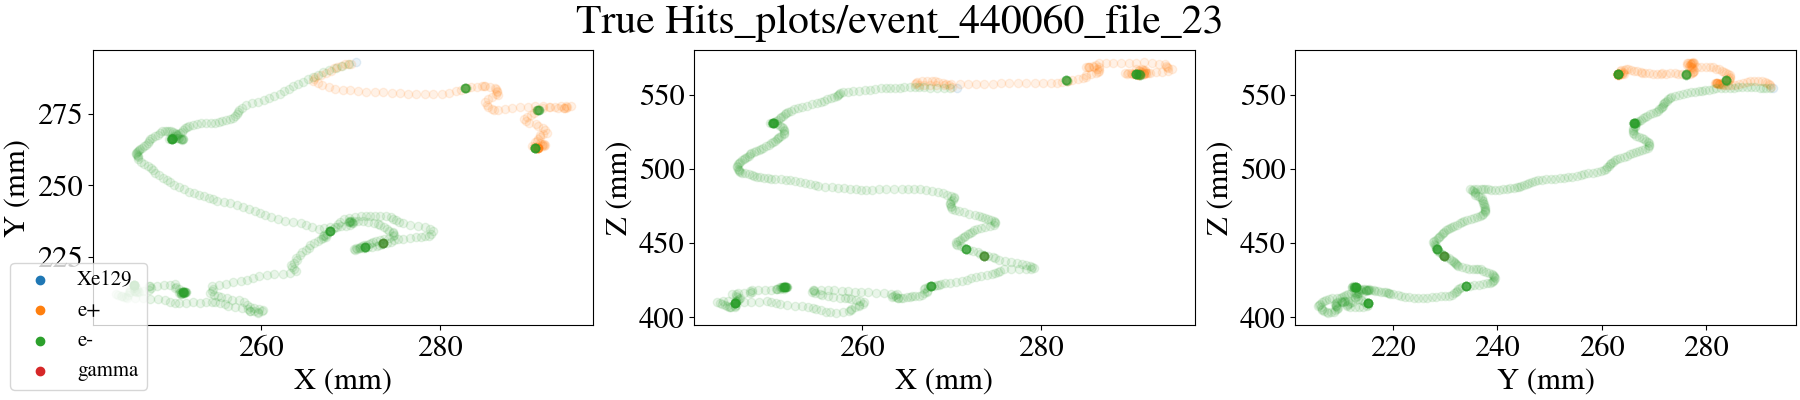

Event: 440136
Number of true tracks: 1
Number of satkill tracks: 1
Number of non-satkill tracks: 1



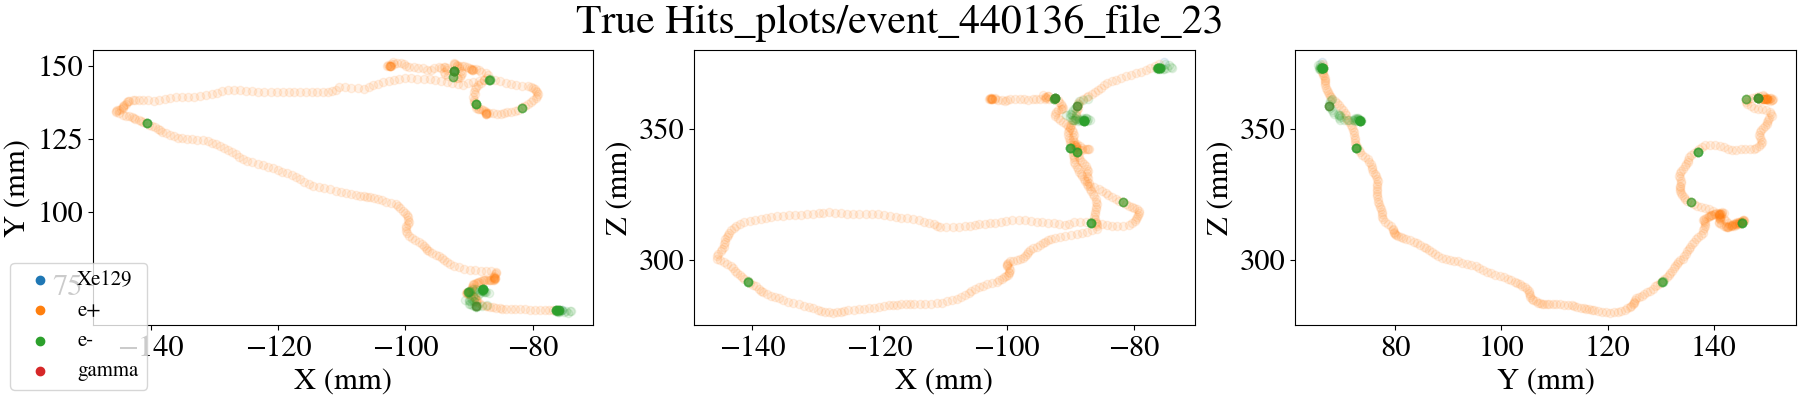

Event: 440140
Number of true tracks: 1
Number of satkill tracks: 1
Number of non-satkill tracks: 6



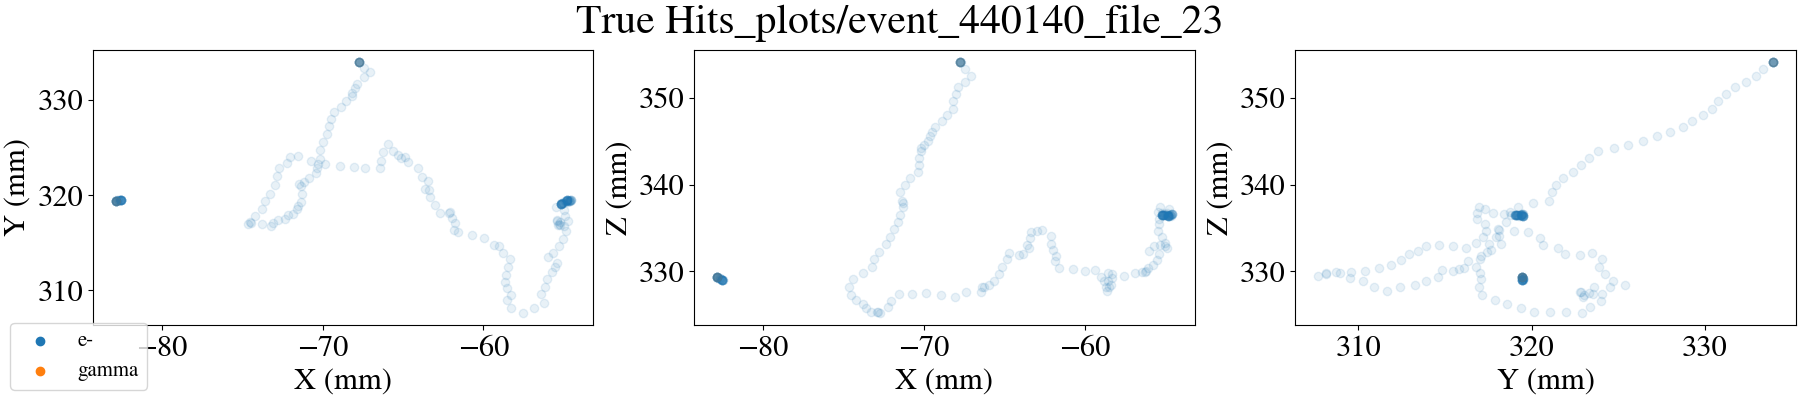

Event: 440276
Number of true tracks: 1
Number of satkill tracks: 1
Number of non-satkill tracks: 5



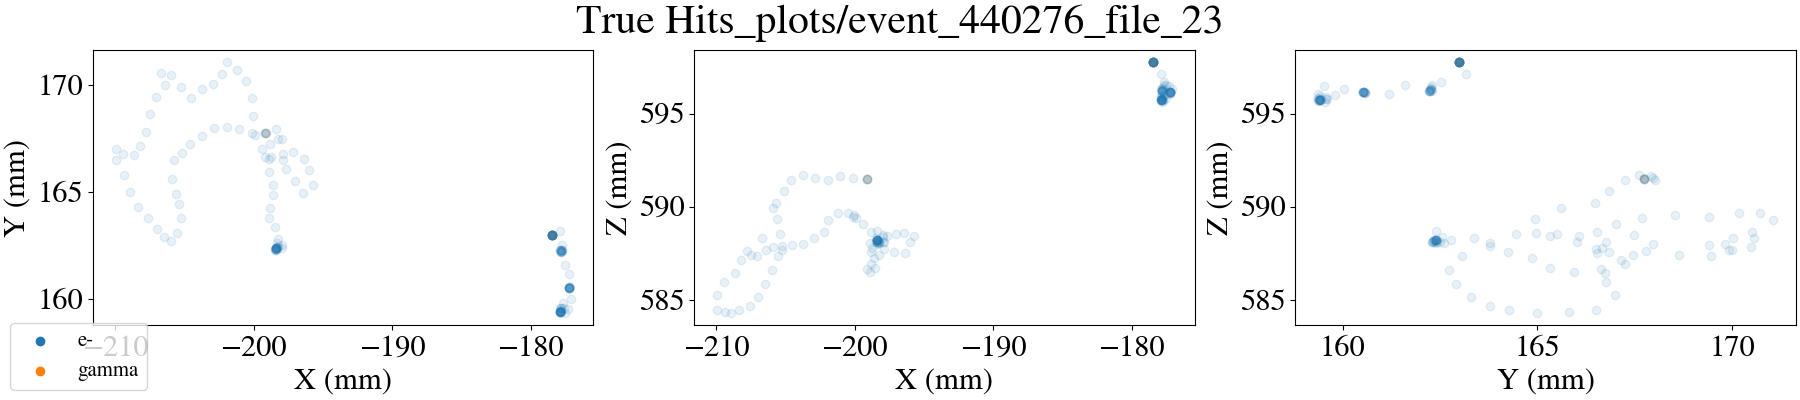

Event: 440446
Number of true tracks: 1
Number of satkill tracks: 1
Number of non-satkill tracks: 1



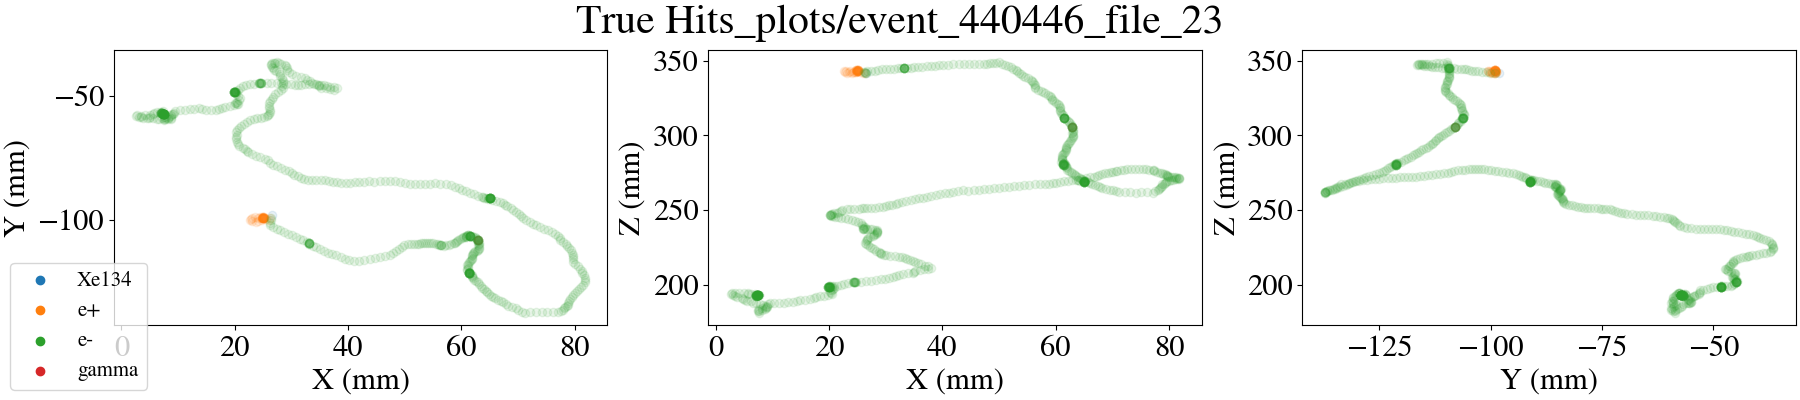

Event: 440536
Number of true tracks: 1
Number of satkill tracks: 1
Number of non-satkill tracks: 2



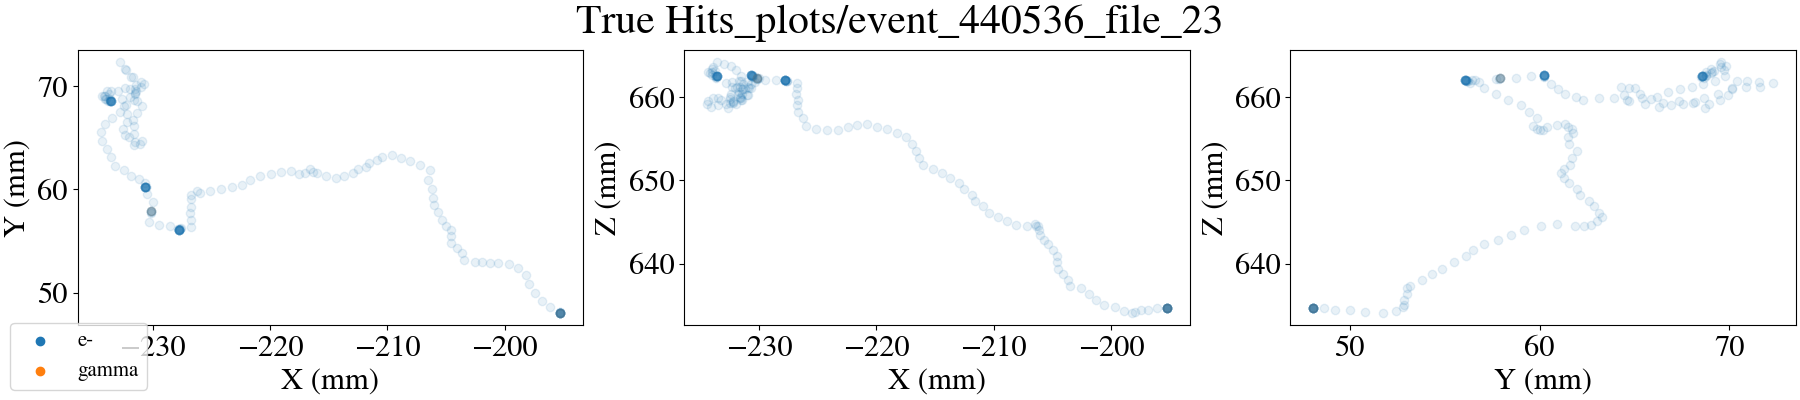

Event: 440546
Number of true tracks: 1
Number of satkill tracks: 1
Number of non-satkill tracks: 3



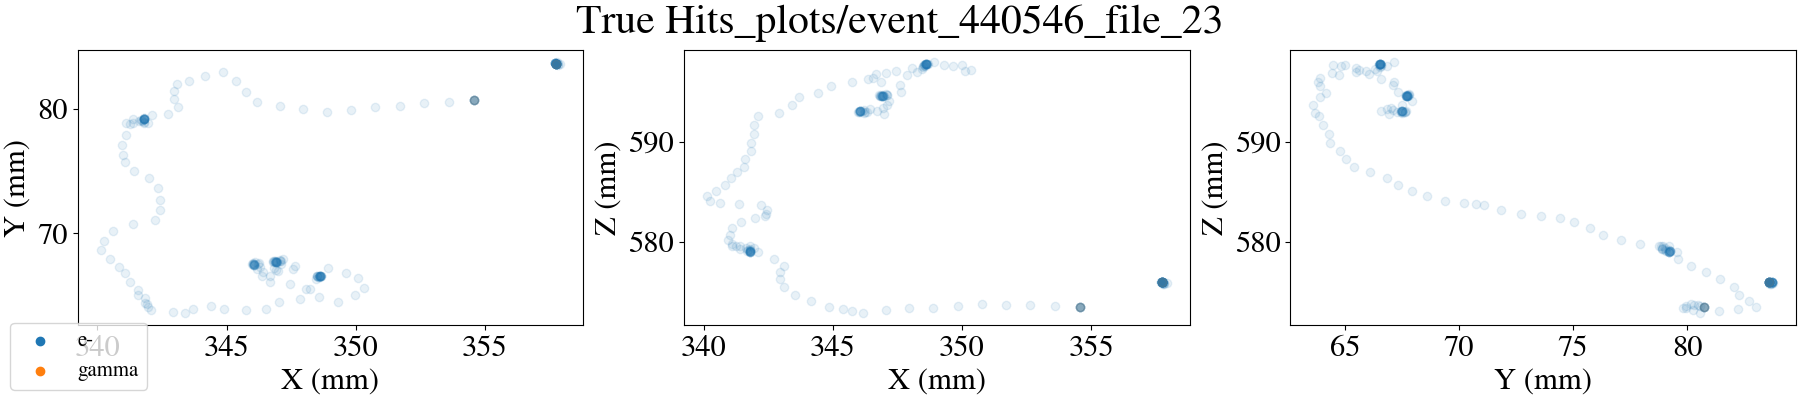

Event: 440576
Number of true tracks: 1
Number of satkill tracks: 1
Number of non-satkill tracks: 1



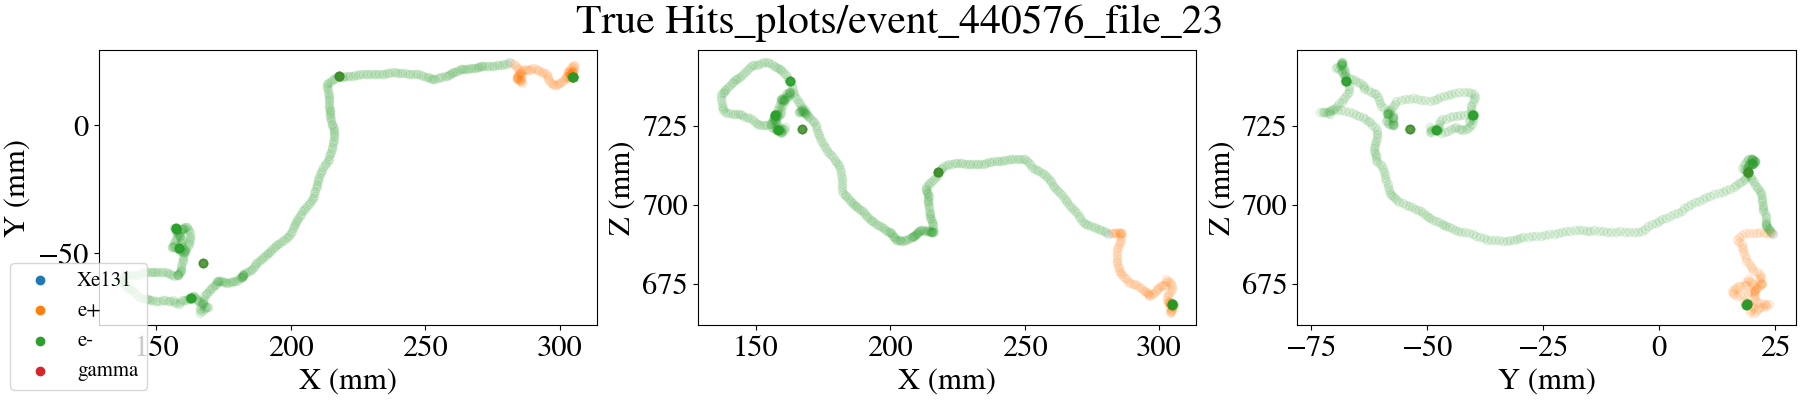

In [26]:
from IPython.display import Image

event_ids_nosat = list(event_ids_nosat)
event_ids = list(event_ids)


for i in range(len(event_ids)):
    value_satkill = i
    test_true = true_trk_number[value_satkill]
    try:
        test_true_nosat = event_ids_nosat.index(event_ids[value_satkill])
    except ValueError:
        #print("Event {} isn't in no-satkill".format(event_ids[value_satkill]))
        #print("")
        test_true_nosat = 0
    test_reco = track_number[value_satkill]
    test_reco_nosat = track_number_nosat[test_true_nosat]
    if (test_true ==1) and (test_reco == 1) and (event_ids[value_satkill] in posi_evt_ids):
        print("Event: {}".format(event_ids[value_satkill]))
        #print("Event: {}".format(event_ids_nosat[test_true_nosat]))
        print("Number of true tracks: {}".format(test_true))
        print("Number of satkill tracks: {}".format(test_reco))
        print("Number of non-satkill tracks: {}".format(test_reco_nosat))

        print("")
        addr = 'plots/event_' + str(event_ids[value_satkill]) + '_file_' + str(file_no) +  '/MC_true.png'
        display(Image(filename=addr))
    

#q[35:40] 37
#print(q[value])
#print(event_ids[value])
#print(track_number[value])
#print()


In [25]:
value_satkill = 5
value_nosatkill = 5


print("Event: {}".format(event_ids[value_satkill]))
print("Event: {}".format(event_ids_nosat[value_nosatkill]))
print("Number of true tracks: {}".format(true_trk_number[value_satkill]))
print("Number of satkill tracks: {}".format(track_number[value_satkill]))
print("Number of non-satkill tracks: {}".format(track_number_nosat[value_nosatkill]))

Event: 440052
Event: 440052
Number of true tracks: 1
Number of satkill tracks: 1
Number of non-satkill tracks: 1


Text(0, 0.5, 'count')

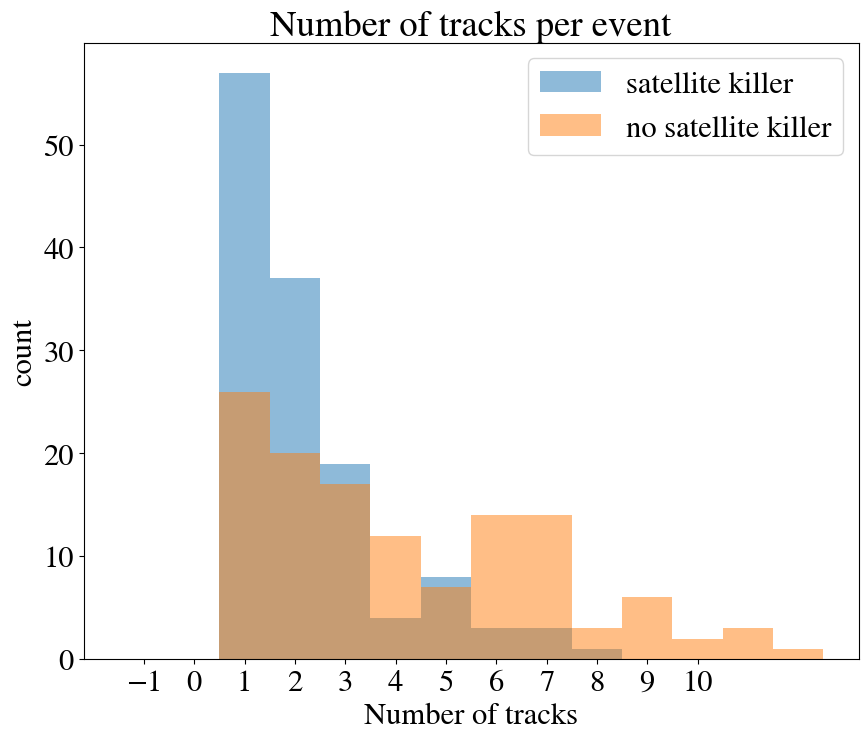

In [29]:
# FIX THE RANGES
plt.hist(track_number, label = 'satellite killer', alpha = 0.5, bins=np.arange(-1,10)-0.5)
plt.hist(track_number_nosat, label = 'no satellite killer', alpha = 0.5, bins = np.arange(-1,14)-0.5)
plt.xticks(np.arange(-1, 11, 1.0))
plt.title('Number of tracks per event')
plt.xlabel('Number of tracks')
plt.legend()
plt.ylabel('count')

### Plot voxelised plot

In [32]:
# generate the deconv
evt = 440536

# check first that the MCof this event is within the 
this_evt_true_info = true_info[true_info.event_id == evt]

# this line applies the satellite killer
deconv_params_['satellite_iter'] = 9999

# hou need to load in hdst already
hits = hdst[hdst.event == evt]



x_range, y_range, z_range, mid_x, mid_y, mid_z, min_x, min_y, min_z, max_x, max_y, max_z, xbins, ybins, zbins = collect_min_max_bins(hits)



hits_cut = coref.timefunc(cut_sensors)(hits.copy())
hits_drop = coref.timefunc(drop_sensors)(hits_cut.copy())

# this is to stop your number of iterations vanishing because of the below function, as you're rewriting deconv_params_
if 'save_state' in locals():
    deconv_params_['n_iterations'] = save_state
else:
    # first time round, so set it
    save_state = deconv_params_['n_iterations']


deconvolver = beerfun.deconvolve_signal(DataSiPM(detector_db, run_number), **deconv_params_)

hits_deco = coref.timefunc(deconvolver)(hits_drop.copy())

Time spent in cut_over_Q: 0.021268129348754883 s
Time spent in drop_isolated: 0.0206296443939209 s
Time spent in apply_deconvolution: 3.6818363666534424 s


2


/tmp/ipykernel_1501904/1363641268.py:74: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


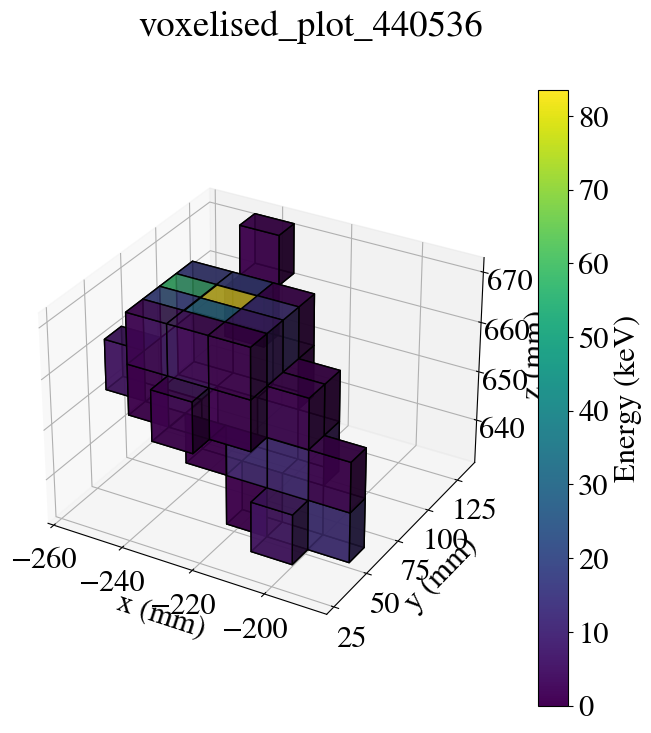

In [33]:
# stuff needed for paolina track counting
energy_threshold = 10
min_voxels = 3
    

base_vsize = 12 #mm
the_hits = []

xs = hits_deco.X
ys = hits_deco.Y
zs = hits_deco.Z
es = hits_deco.E

for x, y, z, e in zip(xs, ys, zs, es):
    if np.isnan(e): continue
    h = Hit(0, Cluster(0, xy(x,y), xy(0,0), 0), z, e*1000, xy(0,0))
    the_hits.append(h)

voxels = voxelize_hits(the_hits,
                       np.array([base_vsize, base_vsize, base_vsize]), False)

(voxels, dropped_voxels) = drop_end_point_voxels(voxels, energy_threshold, min_voxels)


tracks = make_track_graphs(voxels)
tracks = sorted(tracks, key=get_track_energy, reverse = True)

track_no = 0
for c, t in enumerate(tracks, 0):
    track_no += 1

print(track_no)
# drop voxels below certain energy

vsizex = voxels[0].size[0]
vsizey = voxels[0].size[1]
vsizez = voxels[0].size[2]

min_corner_x = min(v.X for v in voxels) - vsizex/2.
min_corner_y = min(v.Y for v in voxels) - vsizey/2.
min_corner_z = min(v.Z for v in voxels) - vsizez/2.

x = [np.round(v.X/vsizex) for v in voxels]
y = [np.round(v.Y/vsizey) for v in voxels]
z = [np.round(v.Z/vsizez) for v in voxels]
e = [v.E for v in voxels]

x_min = int(min(x))
y_min = int(min(y))
z_min = int(min(z))

x_max = int(max(x))
y_max = int(max(y))
z_max = int(max(z))

#print(f'X min = {x_min}, X max = {x_max}')
#print(f'Y min = {y_min}, Y max = {y_max}')
#print(f'Z min = {z_min}, Z max = {z_max}')

VOXELS = np.zeros((x_max-x_min+1, y_max-y_min+1, z_max-z_min+1))
#print(VOXELS.shape)

# sort through the event set the "turn on" the hit voxels
cmap = cm.viridis
norm = Normalize(vmin=0, vmax=max(e))

colors = np.empty(VOXELS.shape, dtype=object)
for q in range(0,len(z)):
    VOXELS[int(x[q])-x_min][int(y[q])-y_min][int(z[q])-z_min] = 1
    colors[int(x[q])-x_min][int(y[q])-y_min][int(z[q])-z_min] = cmap(norm(e[q]))

# and plot everything
fig = plt.figure(figsize=(8,8))
ax = fig.gca(projection='3d')
#a,b,c is spacing in mm needs an extra dim
a,b,c = np.indices((x_max-x_min+2, y_max-y_min+2, z_max-z_min+2))
a = a*vsizex + min_corner_x
b = b*vsizey + min_corner_y
c = c*vsizez + min_corner_z

# a, b, c are the corners of the voxels
ax.voxels(a,b,c, VOXELS, facecolors=colors , edgecolor='k',alpha=0.8)

ax.set_xlabel('x (mm)')#,fontsize=16)
ax.set_ylabel('y (mm)')#,fontsize=16)
ax.set_zlabel('z (mm)')#,fontsize=16)


sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cb = fig.colorbar(sm)
cb.set_label('Energy (keV)')

fig.suptitle('voxelised_plot_' + str(evt))
plt.show()